## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cpu


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of         depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0           1     13.965021     717.887954   -32.080993      -6.880394   
1           2     13.965021     717.887954   -32.080993      -6.880394   
2           3     13.965021     717.887954   -32.080993      -6.880394   
3           4     13.965021     717.887954   -32.080993      -6.880394   
4           5     13.965021     717.887954   -32.080993      -6.880394   
...       ...           ...            ...          ...            ...   
495570     21     17.945001     796.182785   -59.448422     -13.843945   
495571     22     17.945001     796.182785   -59.448422     -13.843945   
495572     23     17.945001     796.182785   -59.448422     -13.843945   
495573     24     17.945001     796.182785   -59.448422     -13.843945   
495574     25     17.945001     796.182785   -59.448422     -13.843945   

        Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0                

In [5]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 19823
Number of training points: 297325


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat01']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'temp_initial00']
m0_output_columns = ['temp_heat01']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [9]:
m1_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'Area_m2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'diffusivity', 'temp_heat01']
m1_output_columns = ['temp_diff02']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./../02_training/saved_models/heat_diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [10]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day', 'temp_diff02']
m2_output_columns = ['temp_mix03']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./../02_training/saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [11]:
m3_input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_mix03']
m3_output_columns = ['temp_conv04']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./../02_training/saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [12]:
m4_input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_conv04']
m4_output_columns = ['temp_total05']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./../02_training/saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [13]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [14]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [15]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [16]:
# Create data set
batch_size = 1000

assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [17]:
print(train_data.shape)
print(test_data.shape)

(297325, 23)
(198250, 23)


In [18]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [19]:
#keeping track of the mean and standard deviations

input_mean, input_std = train_mean[m1_input_column_ix], train_std[m1_input_column_ix]
output_mean, output_std = train_mean[m1_output_column_ix], train_std[m1_output_column_ix]

mean_diff = torch.tensor(input_mean[m1_input_column_ix[13]]).to(device)
std_diff = torch.tensor(input_std[m1_input_column_ix[13]]).to(device)

mean_temp = torch.tensor(input_mean[m1_input_column_ix[14]]).to(device)
std_temp = torch.tensor(input_std[m1_input_column_ix[14]]).to(device)

mean_out = torch.tensor(output_mean).to(device)
std_out = torch.tensor(output_std).to(device)
    
def implicit_diffusion(diff, temp, dt=3600, dx=1, depth_steps=25):
    # de-normalise data
    diff = diff * std_diff + mean_diff
    diff = diff.view(-1, depth_steps)
    
    # INPUT DATA FROM PREVIOUS MODULE
    t = temp * std_temp + mean_temp # temperature profile from previous module output
    t = t.view(-1, depth_steps)
    
    # IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
#     len_t = t.shape[1]
    y = torch.zeros((t.shape[0], depth_steps, depth_steps), dtype=torch.float64).to(device)

    alpha = (dt/dx**2) * diff

    az = - alpha # subdiagonal
    bz = 2 * (1 + alpha) # diagonal
    cz = - alpha # superdiagonal
    
    bz[:, 0] = 1
    az[:, depth_steps-2] = 0
    bz[:, depth_steps-1] = 1
    cz[:, 0] = 0
    
    az = az[:,1:]
    cz = cz[:,:-1]

    y = torch.diag_embed(bz, offset=0)+torch.diag_embed(az,offset=-1)+torch.diag_embed(cz,offset=1) #slightly efficient way of computing the diagonal matrices
    y[:, depth_steps-1, depth_steps-1] = 1
    
    mn = torch.zeros_like(t)  
    mn[:, 0] = t[:, 0]
    mn[:,depth_steps-1] = t[:, depth_steps-1]
    
    mn[:, 1:depth_steps-1] = alpha[:, 1:depth_steps-1]*t[:, :depth_steps-2] + 2 * (1 - alpha[:,1:depth_steps-1])*t[:,1:depth_steps-1] + alpha[:,1:depth_steps-1]*t[:,1:depth_steps-1] #is be same as the loop
    
    # DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
    proj = torch.linalg.solve(y, mn)

    mean, std, var = torch.mean(proj), torch.std(proj), torch.var(proj)
    proj = (proj-mean_out)/std_out

    proj = proj.to(torch.float32)
    proj = proj.view(-1, 1)
    return proj

In [20]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [21]:
print(m1_input_column_ix)
print(m1_input_column_ix[:-1])
print(m1_input_column_ix[:-2])
print(m1_input_column_ix[14])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 13, 14]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 13]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17]
14


In [22]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m4_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m4_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        #m1_input = x[:, m1_input_column_ix]
            
        #model 1
        # m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        
        temp_input = m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
       # print(temp_input)
        
        proj = heat_diff_model(m1_input)
        
        pred = implicit_diffusion(proj, m0_pred)        
        m1_pred = pred.to(dtype=torch.float32)
        
        #print(m1_pred)
        
        if plot:
            m1_y_true = x[:, m1_output_column_ix[0]] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 2
        m2_input = torch.cat([x[:, m2_input_column_ix[:-1]], m1_pred], dim=-1)
        m2_pred = mixing_model(m2_input)
            
        if plot:
            m2_y_true = x[:, m2_output_column_ix] * torch.tensor(train_std[m2_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m2_output_column_ix[0]]).to(device)
            m2_y_pred = m2_pred * torch.tensor(train_std[m2_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m2_output_column_ix[0]]).to(device)
            rmse_models[ix, 2] = rmse(m2_y_true.squeeze(), m2_y_pred.squeeze())
            print("RMSE of after m2", rmse(m2_y_true.flatten(), m2_y_pred.flatten()))

        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m2_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            m3_y_pred = m3_pred * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m3", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
            
        if plot:
            m4_y_true = x[:, m4_output_column_ix] * std + mean
            m4_y_pred = m4_pred * std + mean
            rmse_models[ix, 4] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
            print("RMSE of after m4", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))

        y_true = x[:, m4_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m4_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [23]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='seismic', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='seismic', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [24]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0018987029
RMSE of after m1 0.007228111
RMSE of after m2 0.023938864
RMSE of after m3 0.02434593
RMSE of after m4 0.024347665
RMSE of after m0 0.0017609308
RMSE of after m1 0.01561268
RMSE of after m2 0.114945896
RMSE of after m3 0.114976674
RMSE of after m4 0.11498148
RMSE of after m0 0.0013842721
RMSE of after m1 0.009435397
RMSE of after m2 0.046086617
RMSE of after m3 0.046124697
RMSE of after m4 0.046115737
RMSE of after m0 0.0017147273
RMSE of after m1 0.008467855
RMSE of after m2 0.046246048
RMSE of after m3 0.047490332
RMSE of after m4 0.04750018
RMSE of after m0 0.0020129106
RMSE of after m1 0.00924218
RMSE of after m2 0.02640649
RMSE of after m3 0.02915385
RMSE of after m4 0.029179655
RMSE of after m0 0.0015240337
RMSE of after m1 0.0056566345
RMSE of after m2 0.013815532
RMSE of after m3 0.014077188
RMSE of after m4 0.014113789
RMSE of after m0 0.0014777486
RMSE of after m1 0.008414377
RMSE of after m2 0.053333074
RMSE of after m3 0.053394098
RMSE of after

RMSE of after m0 0.001523877
RMSE of after m1 0.013056398
RMSE of after m2 0.07420054
RMSE of after m3 0.07529779
RMSE of after m4 0.0752949
RMSE of after m0 0.0011978961
RMSE of after m1 0.008682527
RMSE of after m2 0.016183915
RMSE of after m3 0.017235706
RMSE of after m4 0.017222237
RMSE of after m0 0.0010824098
RMSE of after m1 0.00608306
RMSE of after m2 0.016380476
RMSE of after m3 0.017887462
RMSE of after m4 0.017884992
RMSE of after m0 0.0013116983
RMSE of after m1 0.009599426
RMSE of after m2 0.06056522
RMSE of after m3 0.06126237
RMSE of after m4 0.061254334
RMSE of after m0 0.0016692464
RMSE of after m1 0.007697361
RMSE of after m2 0.02233453
RMSE of after m3 0.027155563
RMSE of after m4 0.027120681
RMSE of after m0 0.0014332477
RMSE of after m1 0.007595434
RMSE of after m2 0.033235025
RMSE of after m3 0.035592683
RMSE of after m4 0.035563998
RMSE of after m0 0.0010906997
RMSE of after m1 0.0061691017
RMSE of after m2 0.016234374
RMSE of after m3 0.017008966
RMSE of after m

RMSE of after m0 0.0014164976
RMSE of after m1 0.007097588
RMSE of after m2 0.032557707
RMSE of after m3 0.033325348
RMSE of after m4 0.033330686
RMSE of after m0 0.0013144973
RMSE of after m1 0.0091547845
RMSE of after m2 0.052735195
RMSE of after m3 0.05308672
RMSE of after m4 0.053088307
RMSE of after m0 0.0011139225
RMSE of after m1 0.009710124
RMSE of after m2 0.060365252
RMSE of after m3 0.060421836
RMSE of after m4 0.060412217
RMSE of after m0 0.0014436321
RMSE of after m1 0.021203069
RMSE of after m2 0.17642437
RMSE of after m3 0.17634007
RMSE of after m4 0.17632818
RMSE of after m0 0.0014676702
RMSE of after m1 0.014479118
RMSE of after m2 0.059701666
RMSE of after m3 0.060220566
RMSE of after m4 0.060199384
RMSE of after m0 0.0014128822
RMSE of after m1 0.00936586
RMSE of after m2 0.024120588
RMSE of after m3 0.025134066
RMSE of after m4 0.025112538
RMSE of after m0 0.0012307038
RMSE of after m1 0.007537169
RMSE of after m2 0.017852666
RMSE of after m3 0.018357312
RMSE of aft

RMSE of after m4 0.049847957
RMSE of after m0 0.0016237966
RMSE of after m1 0.008375953
RMSE of after m2 0.018435933
RMSE of after m3 0.022718223
RMSE of after m4 0.022677716
RMSE of after m0 0.0016650449
RMSE of after m1 0.0066868286
RMSE of after m2 0.015664622
RMSE of after m3 0.017711941
RMSE of after m4 0.017679276
RMSE of after m0 0.0014417986
RMSE of after m1 0.0062192637
RMSE of after m2 0.021404294
RMSE of after m3 0.021650642
RMSE of after m4 0.02162264
RMSE of after m0 0.0016922688
RMSE of after m1 0.008942912
RMSE of after m2 0.024572324
RMSE of after m3 0.024923267
RMSE of after m4 0.024963947
RMSE of after m0 0.0018791299
RMSE of after m1 0.009173666
RMSE of after m2 0.053636186
RMSE of after m3 0.053769596
RMSE of after m4 0.053787153
RMSE of after m0 0.0020395867
RMSE of after m1 0.011457661
RMSE of after m2 0.0663832
RMSE of after m3 0.06650878
RMSE of after m4 0.06651387
RMSE of after m0 0.0018119051
RMSE of after m1 0.010345725
RMSE of after m2 0.055919204
RMSE of af

RMSE of after m3 0.054495905
RMSE of after m4 0.05450381
RMSE of after m0 0.0013807728
RMSE of after m1 0.00706292
RMSE of after m2 0.02593295
RMSE of after m3 0.02898028
RMSE of after m4 0.028968181
RMSE of after m0 0.0019023775
RMSE of after m1 0.006788716
RMSE of after m2 0.025556978
RMSE of after m3 0.031229615
RMSE of after m4 0.031215435
RMSE of after m0 0.0013909484
RMSE of after m1 0.008289776
RMSE of after m2 0.042351816
RMSE of after m3 0.04339862
RMSE of after m4 0.04339779
RMSE of after m0 0.0010190296
RMSE of after m1 0.0065815514
RMSE of after m2 0.021865113
RMSE of after m3 0.022067646
RMSE of after m4 0.022060085
RMSE of after m0 0.0012078836
RMSE of after m1 0.008652197
RMSE of after m2 0.041783474
RMSE of after m3 0.041863635
RMSE of after m4 0.041868817
RMSE of after m0 0.0012780824
RMSE of after m1 0.010466617
RMSE of after m2 0.064032294
RMSE of after m3 0.06408443
RMSE of after m4 0.06409554
RMSE of after m0 0.0013225102
RMSE of after m1 0.010170479
RMSE of after 

RMSE of after m0 0.0010069673
RMSE of after m1 0.008992643
RMSE of after m2 0.059153542
RMSE of after m3 0.059262846
RMSE of after m4 0.059267446
RMSE of after m0 0.0012052056
RMSE of after m1 0.01384345
RMSE of after m2 0.11815323
RMSE of after m3 0.11816652
RMSE of after m4 0.11814943
Train RMSE Simulated: 0.050139788538217545
Train RMSE Observed Temp: 3.6675326824188232
Train L2 Error: 0.0032696612179279327
The RMSEs after each modelling stage: [0.00139311 0.00891088 0.04343018 0.04422963 0.04422761]


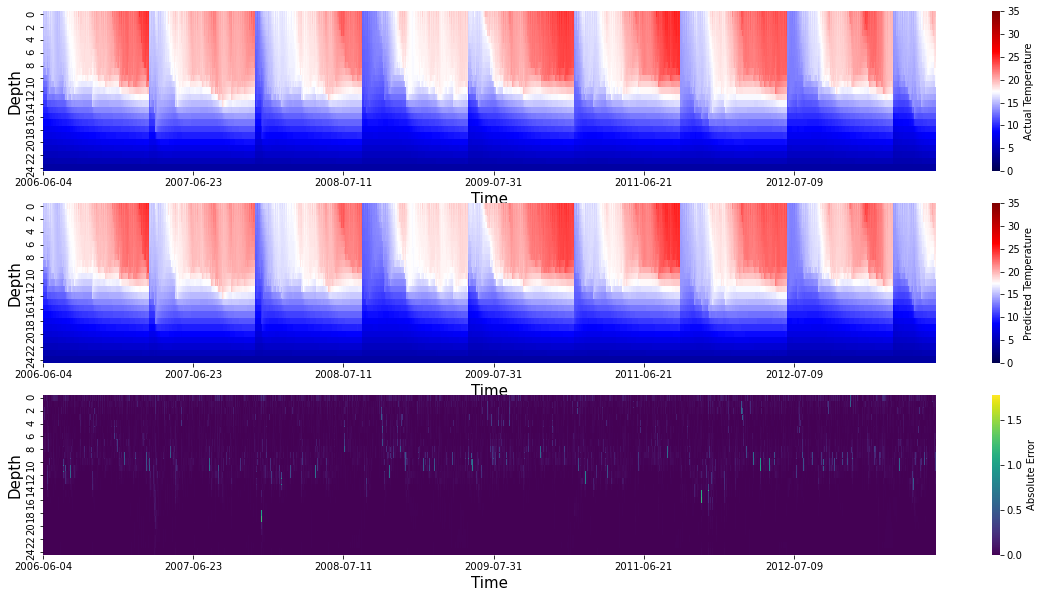

In [25]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

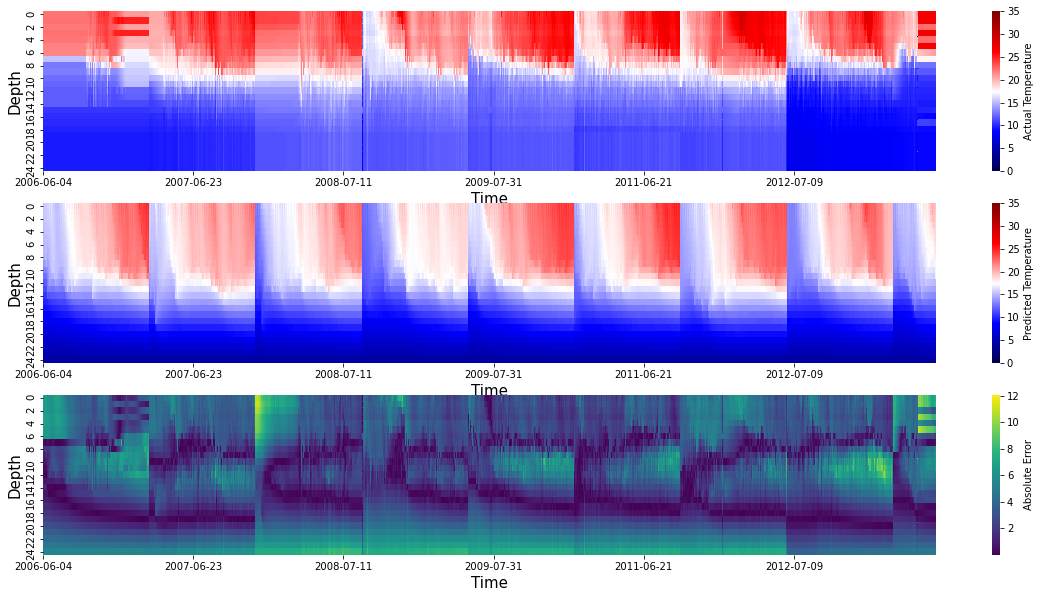

In [26]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [27]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0011541428
RMSE of after m1 0.016101565
RMSE of after m2 0.09536987
RMSE of after m3 0.09543229
RMSE of after m4 0.09542019
RMSE of after m0 0.0012884701
RMSE of after m1 0.012483439
RMSE of after m2 0.048801947
RMSE of after m3 0.049057692
RMSE of after m4 0.049076643
RMSE of after m0 0.0013549231
RMSE of after m1 0.012336481
RMSE of after m2 0.06394777
RMSE of after m3 0.06439265
RMSE of after m4 0.06439663
RMSE of after m0 0.001573939
RMSE of after m1 0.008851846
RMSE of after m2 0.025957342
RMSE of after m3 0.031159176
RMSE of after m4 0.031139994
RMSE of after m0 0.0014333202
RMSE of after m1 0.0115318345
RMSE of after m2 0.07240617
RMSE of after m3 0.07389846
RMSE of after m4 0.07389637
RMSE of after m0 0.0013656919
RMSE of after m1 0.0100127235
RMSE of after m2 0.033582658
RMSE of after m3 0.034195893
RMSE of after m4 0.034216214
RMSE of after m0 0.0011776322
RMSE of after m1 0.011196873
RMSE of after m2 0.060541578
RMSE of after m3 0.060778193
RMSE of after m

RMSE of after m0 0.0011733468
RMSE of after m1 0.008269353
RMSE of after m2 0.04095567
RMSE of after m3 0.041046374
RMSE of after m4 0.041052252
RMSE of after m0 0.00119227
RMSE of after m1 0.011672054
RMSE of after m2 0.05448863
RMSE of after m3 0.054763343
RMSE of after m4 0.054760024
RMSE of after m0 0.001180947
RMSE of after m1 0.0085955635
RMSE of after m2 0.031038353
RMSE of after m3 0.031313583
RMSE of after m4 0.03131362
RMSE of after m0 0.0012129402
RMSE of after m1 0.006806074
RMSE of after m2 0.016430771
RMSE of after m3 0.017672477
RMSE of after m4 0.017683484
RMSE of after m0 0.0013220266
RMSE of after m1 0.013557732
RMSE of after m2 0.08054463
RMSE of after m3 0.08064338
RMSE of after m4 0.08064236
RMSE of after m0 0.0012279205
RMSE of after m1 0.00876306
RMSE of after m2 0.028006213
RMSE of after m3 0.028511014
RMSE of after m4 0.0285217
RMSE of after m0 0.0014105397
RMSE of after m1 0.007033372
RMSE of after m2 0.018760107
RMSE of after m3 0.02297491
RMSE of after m4 0.

RMSE of after m1 0.008641134
RMSE of after m2 0.029505815
RMSE of after m3 0.030165441
RMSE of after m4 0.030156024
RMSE of after m0 0.0014889527
RMSE of after m1 0.008211875
RMSE of after m2 0.023133233
RMSE of after m3 0.02328755
RMSE of after m4 0.023279902
RMSE of after m0 0.0014912321
RMSE of after m1 0.009699809
RMSE of after m2 0.047740817
RMSE of after m3 0.04780709
RMSE of after m4 0.04780048
RMSE of after m0 0.0015253456
RMSE of after m1 0.012889215
RMSE of after m2 0.08471043
RMSE of after m3 0.0847443
RMSE of after m4 0.08473388
RMSE of after m0 0.0013332223
RMSE of after m1 0.013201491
RMSE of after m2 0.042897504
RMSE of after m3 0.043050446
RMSE of after m4 0.04304219
RMSE of after m0 0.0012206625
RMSE of after m1 0.010568687
RMSE of after m2 0.055941854
RMSE of after m3 0.056151498
RMSE of after m4 0.05614698
RMSE of after m0 0.0017058859
RMSE of after m1 0.012309212
RMSE of after m2 0.07417599
RMSE of after m3 0.074246615
RMSE of after m4 0.07424026
RMSE of after m0 0.

RMSE of after m0 0.00114537
RMSE of after m1 0.009856698
RMSE of after m2 0.023407398
RMSE of after m3 0.024042653
RMSE of after m4 0.024038004
RMSE of after m0 0.0015737303
RMSE of after m1 0.008436179
RMSE of after m2 0.025754122
RMSE of after m3 0.02791039
RMSE of after m4 0.027931746
RMSE of after m0 0.0016459344
RMSE of after m1 0.007399033
RMSE of after m2 0.01494119
RMSE of after m3 0.021382097
RMSE of after m4 0.021464206
RMSE of after m0 0.0012389956
RMSE of after m1 0.0062848576
RMSE of after m2 0.013686303
RMSE of after m3 0.014477508
RMSE of after m4 0.014619087
Test RMSE Simulated: 0.049073658883571625
Test RMSE Observed Temp: 3.9087917804718018
test L2 Error: 0.0031768125481903553
The RMSEs after each modelling stage: [0.00140803 0.00918628 0.0428099  0.04372136 0.04371848]


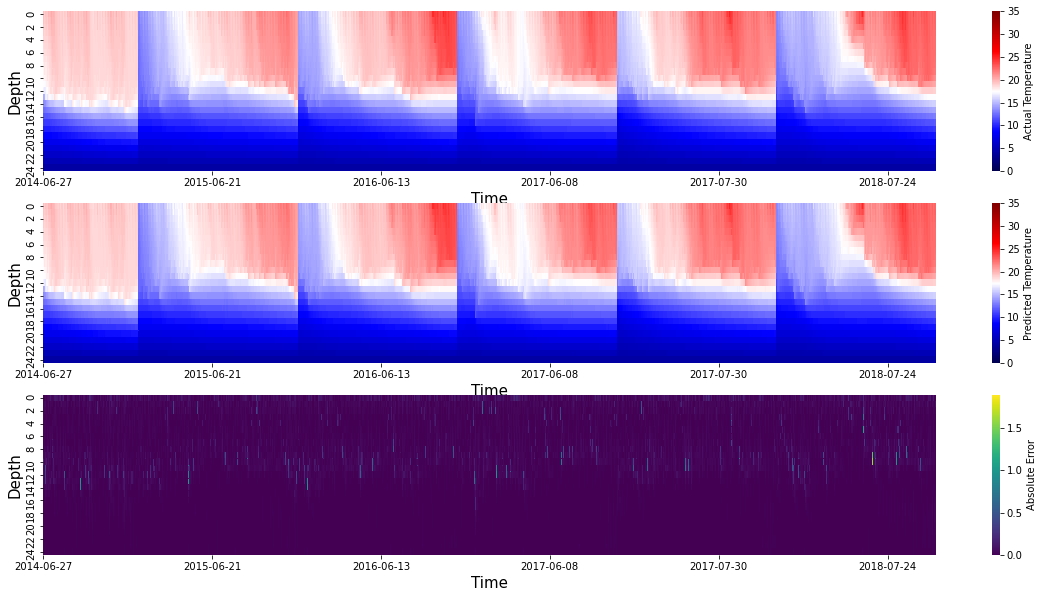

In [28]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

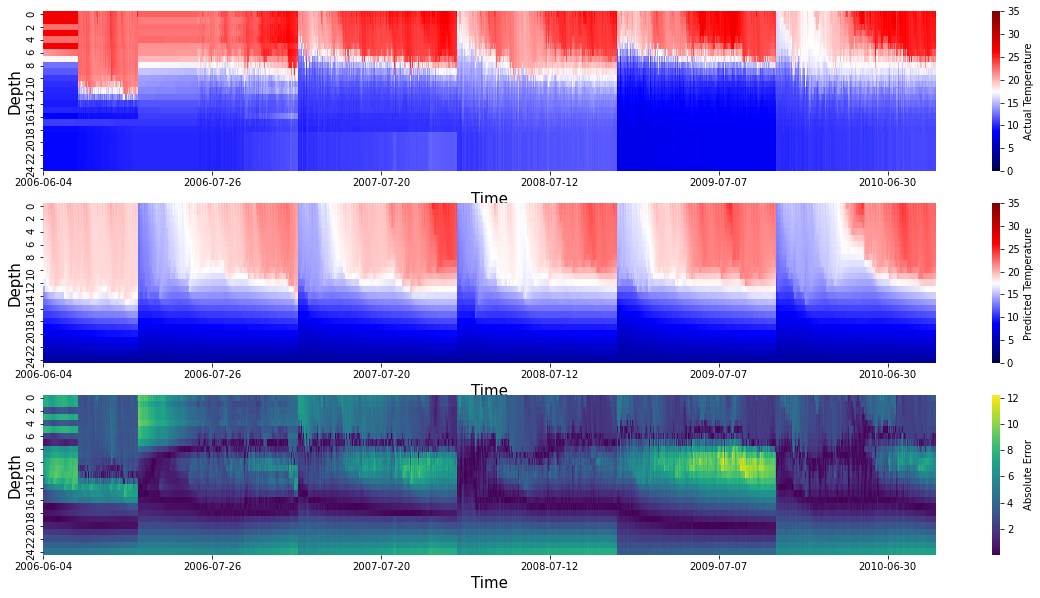

In [29]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [30]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 12.78374249688134, Train L2 Error: 0.8337427173504972
Test RMSE: 12.898444002772136, Train L2 Error: 0.8351028717356513


## Mixing Model

In [31]:
train_rmse, train_l2_err = compute_metrics(mixing_model, train_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(mixing_model, test_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.04697958908507593, Train L2 Error: 0.0030637252879735055
Test RMSE: 0.04598526649073426, Train L2 Error: 0.0029770726607876415


## Convection Model

In [32]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.004543179681784685, Train L2 Error: 0.0002962804739826945
Test RMSE: 0.004928978264442002, Train L2 Error: 0.00031910286552458325


## Ice Model

In [33]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.00020992106922037695, Train L2 Error: 1.3689864421812881e-05
Test RMSE: 0.00021575026316656776, Train L2 Error: 1.3967707610073765e-05


# Finetuning

In [34]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(mixing_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [35]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [36]:
#freeze_model(heating_model)
freeze_model(mixing_model)
freeze_model(convection_model)
freeze_model(ice_model)
unfreeze_model(heat_diff_model)
freeze_model(heating_model)

In [37]:
diffusivity = torch.load('diffusivity.t')

#print(diffusivity)


# Finetuning on Observed Temperature

In [38]:
heating_model.train()
heat_diff_model.train()
mixing_model.train()
convection_model.train()
ice_model.train()

n_epochs = 500

# mean and standard dev of "temp_total04" of model 4 output
mean_out4 = torch.tensor(train_mean[m4_output_column_ix[0]]).float().to(device)
std_out4 = torch.tensor(train_std[m4_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        

        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        m1_pred = heat_diff_model(m1_input)
        #pred = implicit_diffusion(proj, m0_pred)        
        #m1_pred = pred.to(dtype=torch.float32)
        

        #print(torch.stack(diffusivity))
        
       # torch_diffusivity = torch.Tensor(diffusivity)

        loss_m1 = criterion(m1_pred, diffusivity[ix])
        
        loss = loss_m1
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()

    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)

    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)

    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]}")
    
    #plot the loss_m1, m2

  0%|          | 1/500 [00:02<17:02,  2.05s/it]

Epoch : 0, Train_loss: 1942.4414603214136, Loss m0: 6.833796524636602e-08, Loss m1: 1942.4414603214136


 10%|█         | 51/500 [01:34<13:41,  1.83s/it]

Epoch : 50, Train_loss: 1520.0163123623636, Loss m0: 6.833796524636602e-08, Loss m1: 1520.0163123623636


 20%|██        | 101/500 [03:09<13:41,  2.06s/it]

Epoch : 100, Train_loss: 604.0271502245192, Loss m0: 6.833796524636602e-08, Loss m1: 604.0271502245192


 30%|███       | 151/500 [04:52<11:52,  2.04s/it]

Epoch : 150, Train_loss: 14.640016899812942, Loss m0: 6.833796524636602e-08, Loss m1: 14.640016899812942


 40%|████      | 201/500 [06:34<10:06,  2.03s/it]

Epoch : 200, Train_loss: 4.092218911887815, Loss m0: 6.833796524636602e-08, Loss m1: 4.092218911887815


 50%|█████     | 251/500 [08:16<08:29,  2.05s/it]

Epoch : 250, Train_loss: 2.138355918378638, Loss m0: 6.833796524636602e-08, Loss m1: 2.138355918378638


 60%|██████    | 301/500 [09:59<07:27,  2.25s/it]

Epoch : 300, Train_loss: 1.551070699555762, Loss m0: 6.833796524636602e-08, Loss m1: 1.551070699555762


 70%|███████   | 351/500 [11:42<05:03,  2.03s/it]

Epoch : 350, Train_loss: 1.2028294235667927, Loss m0: 6.833796524636602e-08, Loss m1: 1.2028294235667927


 80%|████████  | 401/500 [13:25<03:25,  2.08s/it]

Epoch : 400, Train_loss: 0.9435760824872343, Loss m0: 6.833796524636602e-08, Loss m1: 0.9435760824872343


 90%|█████████ | 451/500 [15:08<01:39,  2.04s/it]

Epoch : 450, Train_loss: 0.7523757492335851, Loss m0: 6.833796524636602e-08, Loss m1: 0.7523757492335851


100%|██████████| 500/500 [16:48<00:00,  2.02s/it]


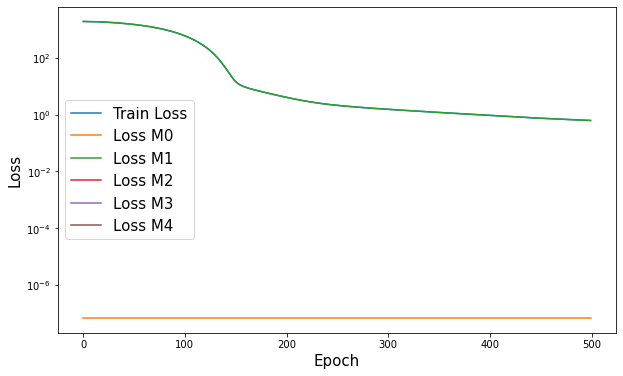

In [39]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [40]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0018987029
RMSE of after m1 0.076992474
RMSE of after m2 0.07621842
RMSE of after m3 0.0757927
RMSE of after m4 0.07584991
RMSE of after m0 0.0017609308
RMSE of after m1 0.11927596
RMSE of after m2 0.16360539
RMSE of after m3 0.16332161
RMSE of after m4 0.16335239
RMSE of after m0 0.0013842721
RMSE of after m1 0.106103055
RMSE of after m2 0.10899189
RMSE of after m3 0.10861531
RMSE of after m4 0.10865284
RMSE of after m0 0.0017147273
RMSE of after m1 0.09209888
RMSE of after m2 0.103273064
RMSE of after m3 0.10390878
RMSE of after m4 0.103918
RMSE of after m0 0.0020129106
RMSE of after m1 0.106254674
RMSE of after m2 0.10731281
RMSE of after m3 0.10812654
RMSE of after m4 0.10814048
RMSE of after m0 0.0015240337
RMSE of after m1 0.07166718
RMSE of after m2 0.07033866
RMSE of after m3 0.07031937
RMSE of after m4 0.07031945
RMSE of after m0 0.0014777486
RMSE of after m1 0.08074109
RMSE of after m2 0.09381675
RMSE of after m3 0.09363022
RMSE of after m4 0.0936258
RMSE o

RMSE of after m0 0.0012467413
RMSE of after m1 0.12356721
RMSE of after m2 0.120513864
RMSE of after m3 0.11927323
RMSE of after m4 0.11926547
RMSE of after m0 0.001480185
RMSE of after m1 0.11750027
RMSE of after m2 0.117395654
RMSE of after m3 0.11657432
RMSE of after m4 0.1166711
RMSE of after m0 0.0020488498
RMSE of after m1 0.078807645
RMSE of after m2 0.08696054
RMSE of after m3 0.08697507
RMSE of after m4 0.08699511
RMSE of after m0 0.0039685215
RMSE of after m1 0.10074161
RMSE of after m2 0.14088507
RMSE of after m3 0.14089818
RMSE of after m4 0.14088699
RMSE of after m0 0.003067321
RMSE of after m1 0.10946638
RMSE of after m2 0.11703288
RMSE of after m3 0.11675856
RMSE of after m4 0.11673968
RMSE of after m0 0.0016961352
RMSE of after m1 0.09781969
RMSE of after m2 0.09952933
RMSE of after m3 0.09915312
RMSE of after m4 0.09915847
RMSE of after m0 0.0014115585
RMSE of after m1 0.09301653
RMSE of after m2 0.10023175
RMSE of after m3 0.099974684
RMSE of after m4 0.09998756
RMSE 

RMSE of after m0 0.001201942
RMSE of after m1 0.11819607
RMSE of after m2 0.12771145
RMSE of after m3 0.12727582
RMSE of after m4 0.12724666
RMSE of after m0 0.0012472782
RMSE of after m1 0.17709082
RMSE of after m2 0.19179225
RMSE of after m3 0.19155914
RMSE of after m4 0.19152056
RMSE of after m0 0.0016305727
RMSE of after m1 0.15100136
RMSE of after m2 0.15222165
RMSE of after m3 0.15276483
RMSE of after m4 0.1527481
RMSE of after m0 0.0012767762
RMSE of after m1 0.09231093
RMSE of after m2 0.091671266
RMSE of after m3 0.090855256
RMSE of after m4 0.09084882
RMSE of after m0 0.0011093977
RMSE of after m1 0.08392886
RMSE of after m2 0.08607407
RMSE of after m3 0.08549993
RMSE of after m4 0.085471034
RMSE of after m0 0.0011544292
RMSE of after m1 0.103178225
RMSE of after m2 0.10034094
RMSE of after m3 0.09953514
RMSE of after m4 0.099518456
RMSE of after m0 0.0013439296
RMSE of after m1 0.101187676
RMSE of after m2 0.1265776
RMSE of after m3 0.1259517
RMSE of after m4 0.12592062
RMSE

RMSE of after m3 0.10807595
RMSE of after m4 0.10804257
RMSE of after m0 0.00090591377
RMSE of after m1 0.14862831
RMSE of after m2 0.14894661
RMSE of after m3 0.14833209
RMSE of after m4 0.14829642
RMSE of after m0 0.001040875
RMSE of after m1 0.15497193
RMSE of after m2 0.1683578
RMSE of after m3 0.1678359
RMSE of after m4 0.1678234
RMSE of after m0 0.0010972169
RMSE of after m1 0.15746766
RMSE of after m2 0.15344283
RMSE of after m3 0.15294276
RMSE of after m4 0.15295911
RMSE of after m0 0.0012939358
RMSE of after m1 0.17353328
RMSE of after m2 0.17107086
RMSE of after m3 0.17100473
RMSE of after m4 0.17108165
RMSE of after m0 0.0012560833
RMSE of after m1 0.13429579
RMSE of after m2 0.1328998
RMSE of after m3 0.13335311
RMSE of after m4 0.13337728
RMSE of after m0 0.0009816784
RMSE of after m1 0.19817683
RMSE of after m2 0.19960423
RMSE of after m3 0.19925143
RMSE of after m4 0.19928122
RMSE of after m0 0.0013989409
RMSE of after m1 0.21838202
RMSE of after m2 0.21852988
RMSE of af

RMSE of after m0 0.0010822562
RMSE of after m1 0.1219777
RMSE of after m2 0.13080105
RMSE of after m3 0.13045001
RMSE of after m4 0.130372
RMSE of after m0 0.0011623073
RMSE of after m1 0.28082523
RMSE of after m2 0.27982506
RMSE of after m3 0.27923504
RMSE of after m4 0.27922666
RMSE of after m0 0.0013045014
RMSE of after m1 0.2337204
RMSE of after m2 0.24239601
RMSE of after m3 0.2420838
RMSE of after m4 0.24207199
RMSE of after m0 0.0014733111
RMSE of after m1 0.21839875
RMSE of after m2 0.22245912
RMSE of after m3 0.22240299
RMSE of after m4 0.22239837
RMSE of after m0 0.0013260011
RMSE of after m1 0.105585285
RMSE of after m2 0.10472213
RMSE of after m3 0.10449121
RMSE of after m4 0.10443841
RMSE of after m0 0.0010649697
RMSE of after m1 0.11990916
RMSE of after m2 0.123364955
RMSE of after m3 0.12304923
RMSE of after m4 0.122994184
RMSE of after m0 0.0010739231
RMSE of after m1 0.107658036
RMSE of after m2 0.112230144
RMSE of after m3 0.111744344
RMSE of after m4 0.11169049
RMSE 

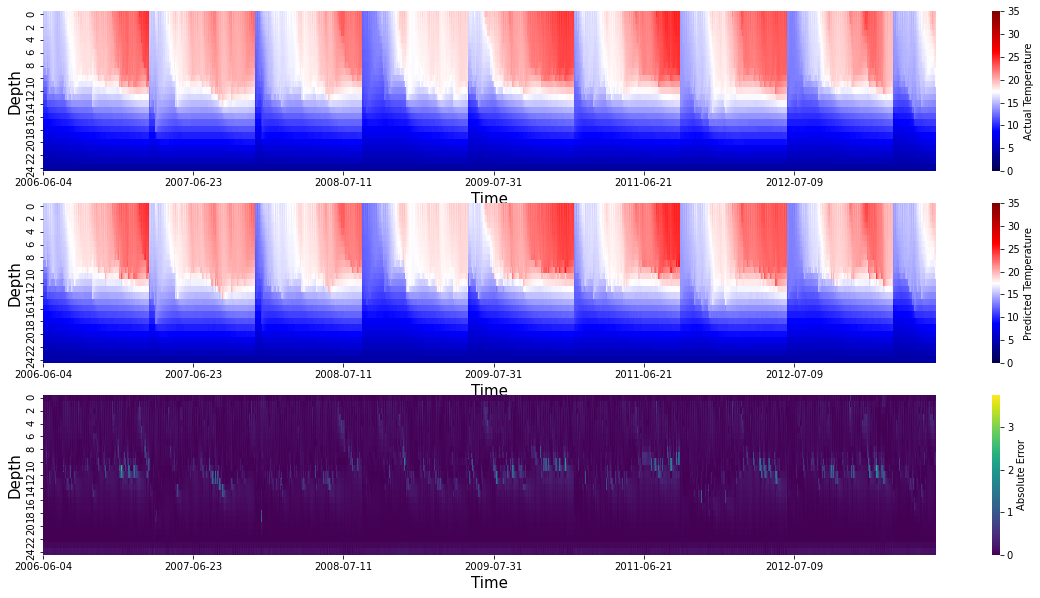

In [41]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

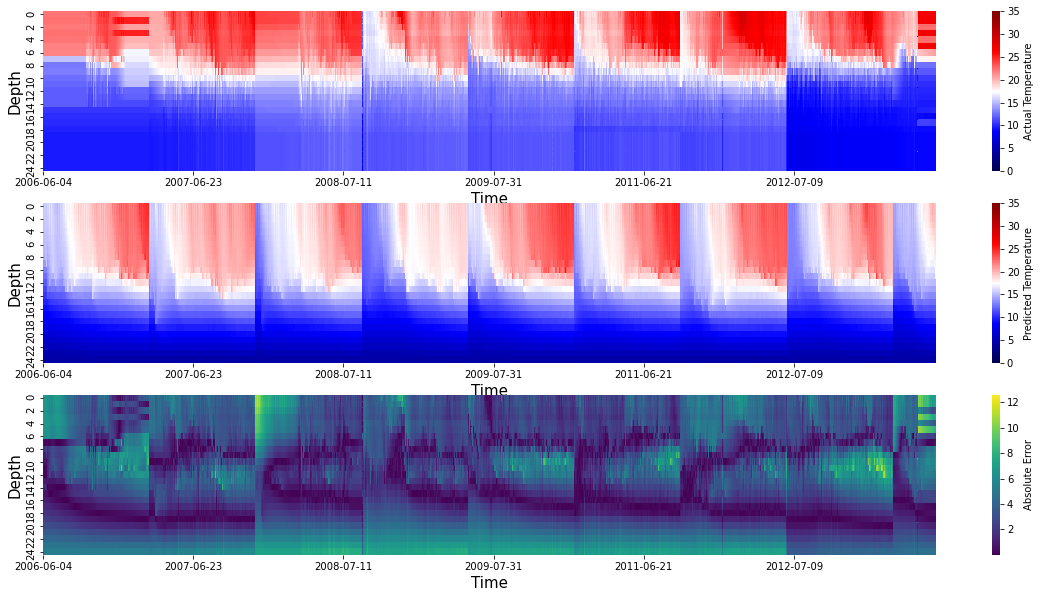

In [42]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [43]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.0011541428
RMSE of after m1 0.20184761
RMSE of after m2 0.22061354
RMSE of after m3 0.2204413
RMSE of after m4 0.22042412
RMSE of after m0 0.0012884701
RMSE of after m1 0.21318656
RMSE of after m2 0.2133586
RMSE of after m3 0.21300617
RMSE of after m4 0.21303032
RMSE of after m0 0.0013549231
RMSE of after m1 0.2080246
RMSE of after m2 0.21577646
RMSE of after m3 0.21528503
RMSE of after m4 0.21535152
RMSE of after m0 0.001573939
RMSE of after m1 0.11703852
RMSE of after m2 0.119449824
RMSE of after m3 0.120711036
RMSE of after m4 0.12070639
RMSE of after m0 0.0014333202
RMSE of after m1 0.12142781
RMSE of after m2 0.14371513
RMSE of after m3 0.14449716
RMSE of after m4 0.14449577
RMSE of after m0 0.0013656919
RMSE of after m1 0.16214888
RMSE of after m2 0.16284616
RMSE of after m3 0.1626267
RMSE of after m4 0.16264458
RMSE of after m0 0.0011776322
RMSE of after m1 0.13976207
RMSE of after m2 0.15290637
RMSE of after m3 0.1526553
RMSE of after m4 0.1526593
RMSE of aft

RMSE of after m0 0.0012129402
RMSE of after m1 0.11146957
RMSE of after m2 0.108852595
RMSE of after m3 0.10879552
RMSE of after m4 0.10871854
RMSE of after m0 0.0013220266
RMSE of after m1 0.2381524
RMSE of after m2 0.24737313
RMSE of after m3 0.24708658
RMSE of after m4 0.24706347
RMSE of after m0 0.0012279205
RMSE of after m1 0.14979745
RMSE of after m2 0.14878875
RMSE of after m3 0.14837353
RMSE of after m4 0.14836036
RMSE of after m0 0.0014105397
RMSE of after m1 0.10366851
RMSE of after m2 0.10372231
RMSE of after m3 0.10429602
RMSE of after m4 0.104250684
RMSE of after m0 0.0013753884
RMSE of after m1 0.1532772
RMSE of after m2 0.15594895
RMSE of after m3 0.15591584
RMSE of after m4 0.15589346
RMSE of after m0 0.0013535393
RMSE of after m1 0.10452649
RMSE of after m2 0.10375303
RMSE of after m3 0.10426209
RMSE of after m4 0.10422494
RMSE of after m0 0.001130668
RMSE of after m1 0.08613486
RMSE of after m2 0.08492854
RMSE of after m3 0.08456142
RMSE of after m4 0.08451227
RMSE of

RMSE of after m2 0.14244153
RMSE of after m3 0.14268206
RMSE of after m4 0.14260177
RMSE of after m0 0.001075866
RMSE of after m1 0.12945625
RMSE of after m2 0.13687307
RMSE of after m3 0.13702646
RMSE of after m4 0.13696617
RMSE of after m0 0.0011435029
RMSE of after m1 0.2116239
RMSE of after m2 0.21166736
RMSE of after m3 0.21145494
RMSE of after m4 0.21142513
RMSE of after m0 0.0010561271
RMSE of after m1 0.1320625
RMSE of after m2 0.13085023
RMSE of after m3 0.13083622
RMSE of after m4 0.1307706
RMSE of after m0 0.0012254425
RMSE of after m1 0.1884694
RMSE of after m2 0.19823724
RMSE of after m3 0.19794801
RMSE of after m4 0.19793293
RMSE of after m0 0.0010641215
RMSE of after m1 0.1978641
RMSE of after m2 0.19713445
RMSE of after m3 0.19687642
RMSE of after m4 0.19685249
RMSE of after m0 0.001507225
RMSE of after m1 0.13707107
RMSE of after m2 0.13833828
RMSE of after m3 0.13804601
RMSE of after m4 0.13800766
RMSE of after m0 0.0014838201
RMSE of after m1 0.23333801
RMSE of after

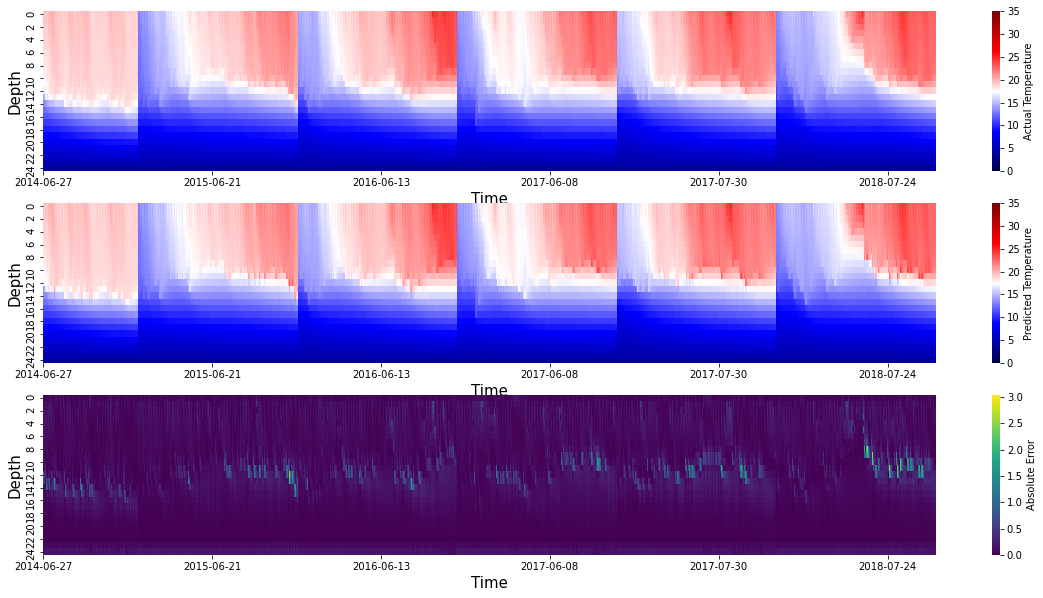

In [44]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

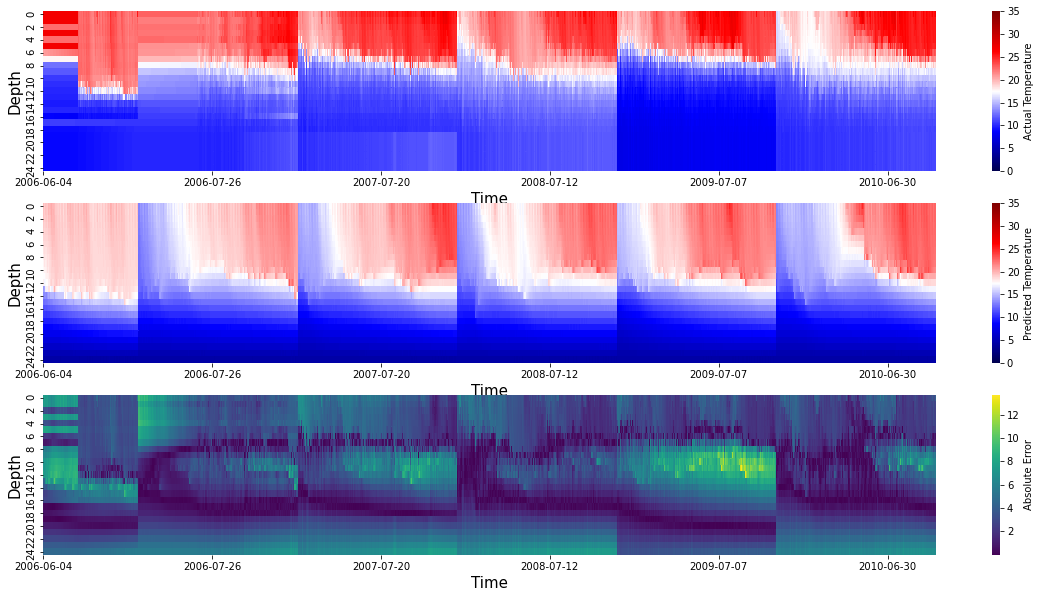

In [45]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [46]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 233.9248903543783, Train L2 Error: 15.256344046945241
Test RMSE: 237.7638190248991, Train L2 Error: 15.39389154380598


## Mixing Model

In [47]:
train_rmse, train_l2_err = compute_metrics(mixing_model, train_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(mixing_model, test_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.04697958908507593, Train L2 Error: 0.0030637252879735055
Test RMSE: 0.04598526649073426, Train L2 Error: 0.0029770726607876415


## Convection Model

In [48]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.004543179681784685, Train L2 Error: 0.0002962804739826945
Test RMSE: 0.004928978264442002, Train L2 Error: 0.00031910286552458325


## Ice Model

In [49]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.00020992106922037695, Train L2 Error: 1.3689864421812881e-05
Test RMSE: 0.00021575026316656776, Train L2 Error: 1.3967707610073765e-05


# Compute Model Similarity after Finetuning

In [50]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [51]:
heating_model_init = MLP(m0_layers, activation="gelu")
heating_model_init.load_state_dict(m0_checkpoint)
heating_model_init = heating_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heating_model_init, heating_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [52]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.7810326218605042
L2 Norm: 9.185251235961914


In [53]:
mixing_model_init = MLP(m2_layers, activation="gelu")
mixing_model_init.load_state_dict(m2_checkpoint)
mixing_model_init = mixing_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(mixing_model_init, mixing_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [54]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [55]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0
